In [1]:
### TODO:
#   - najdi primerni podatkovni bazi za regresijo in klasifikacijo
#   - omogoči naključno rezanje uteži
#   - ustvari lažje podajanje hiperparametrov
#   - !!ročno inicializiraj uteži z Gaussian Glorot initialization ALI Gaussian z standard deviation 0.1
#   - ustvari lepši ui, ki na boljši način prikaže rezanje in učenje.
#   - podatke kot je early stopping rate, natančnost itd. itd. je treba nekje shraniti in prikazati
#   - sproti shranjuj nekatere modele npr. najbolj natančnega, najbolj rezanega ali po vsakem rezanju

In [2]:
import torch
import numpy as np
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchinfo
import matplotlib
from matplotlib import pyplot as plt
from torch.utils.tensorboard import SummaryWriter

from neural_network import *
from iterative_pruning import IterativePruning

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [4]:
NUM_CHANNELS = 10
BATCH_SIZE = 128
NUM_EPOCHS = 100
IMAGE_SIZE = [28, 28]
LR = 1.2e-3

In [5]:
transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
])

##pin_memory in num_workers=6

mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

train_subset, val_subset = torch.utils.data.random_split(mnist_trainset, [50000, 10000], generator=torch.Generator().manual_seed(1))

X_train = train_subset.dataset.data[train_subset.indices]
y_train = train_subset.dataset.targets[train_subset.indices]

X_val = val_subset.dataset.data[val_subset.indices]
y_val = val_subset.dataset.targets[val_subset.indices]

train_loader = DataLoader(dataset=train_subset, shuffle=True, batch_size=BATCH_SIZE)
val_loader = DataLoader(dataset=val_subset, shuffle=False, batch_size=BATCH_SIZE)

mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(mnist_testset, batch_size=BATCH_SIZE, shuffle=True)

Ime zbirke:     MNIST
Velikost učne množice:   60000
Velikost testne množice:   10000
Dimenzija slik: (1, 28, 28)


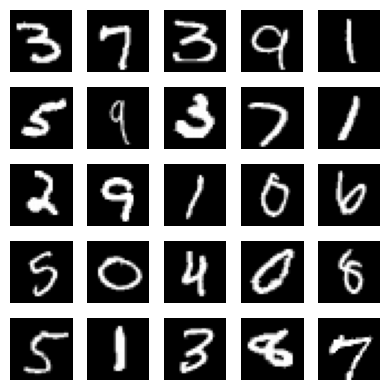

In [6]:
images, _ = next(iter(train_loader))

print(f"Ime zbirke:     MNIST")
print(f"Velikost učne množice:   {len(mnist_trainset)}")
print(f"Velikost testne množice:   {len(mnist_testset)}")
print(f"Dimenzija slik: {images[0].numpy().shape}")

_, axes = plt.subplots(5, 5, figsize=(4, 4), squeeze=False)
for i in range(5):
    for j in range(5):
        axes[i, j].imshow(images[5*i+j].numpy().transpose((1,2,0)), cmap="gray")
        axes[i, j].axis("off")
            
plt.tight_layout()

In [7]:
model = LeNet300(NUM_CHANNELS)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
loss_fn = torch.nn.CrossEntropyLoss()

print(torchinfo.summary(model, (BATCH_SIZE, 1, IMAGE_SIZE[1], IMAGE_SIZE[0])))

Layer (type:depth-idx)                   Output Shape              Param #
LeNet300                                 [128, 10]                 --
├─Linear: 1-1                            [128, 300]                235,500
├─ReLU: 1-2                              [128, 300]                --
├─Linear: 1-3                            [128, 100]                30,100
├─ReLU: 1-4                              [128, 100]                --
├─Linear: 1-5                            [128, 10]                 1,010
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
Total mult-adds (M): 34.13
Input size (MB): 0.40
Forward/backward pass size (MB): 0.42
Params size (MB): 1.07
Estimated Total Size (MB): 1.89


In [8]:
for i, data in enumerate(model.named_parameters()):
    name, param = data
    if "weight" in name:
        print(name)
        print(np.shape(param.data))

linear_1.weight
torch.Size([300, 784])
linear_2.weight
torch.Size([100, 300])
linear_3.weight
torch.Size([10, 100])


In [9]:
ip = IterativePruning(model)

acc, sp = ip.start(loss_fn, train_loader, val_loader, test_loader, LR, NUM_EPOCHS, 2, 0, 0.2)
torch.save(model, "model_lenet_mnist.pt")

 ===| Prune iteration 1/30 |=== 
linear_1.weight      Zeros:        0 Nonzeros:   235200 All:   235200 Remaining:   100.00%
linear_1.bias        Zeros:        0 Nonzeros:      300 All:      300 Remaining:   100.00%
linear_2.weight      Zeros:        0 Nonzeros:    30000 All:    30000 Remaining:   100.00%
linear_2.bias        Zeros:        0 Nonzeros:      100 All:      100 Remaining:   100.00%
linear_3.weight      Zeros:        0 Nonzeros:     1000 All:     1000 Remaining:   100.00%
linear_3.bias        Zeros:        0 Nonzeros:       10 All:       10 Remaining:   100.00%
all                  Zeros:        0 Nonzeros:   266610 All:   266610 Remaining:   100.00%


Epoch: 7, loss: 0.0201, val_loss: 0.0808 Validating: : 79it [00:01, 46.48it/s]                       
Testing: 79it [00:02, 30.08it/s]                        


Accuracy: 0.977


 ===| Prune iteration 2/30 |=== 
linear_1.weight      Zeros:    47040 Nonzeros:   188160 All:   235200 Remaining:    80.00%
linear_1.bias        Zeros:        0 Nonzeros:      300 All:      300 Remaining:   100.00%
linear_2.weight      Zeros:     6000 Nonzeros:    24000 All:    30000 Remaining:    80.00%
linear_2.bias        Zeros:        0 Nonzeros:      100 All:      100 Remaining:   100.00%
linear_3.weight      Zeros:      100 Nonzeros:      900 All:     1000 Remaining:    90.00%
linear_3.bias        Zeros:        0 Nonzeros:       10 All:       10 Remaining:   100.00%
all                  Zeros:    53140 Nonzeros:   213470 All:   266610 Remaining:    80.07%


Epoch: 5, loss: 0.0222, val_loss: 0.0863 Validating: : 79it [00:01, 47.37it/s]                       
Testing: 79it [00:02, 30.33it/s]                        


Accuracy: 0.972


 ===| Prune iteration 3/30 |=== 
linear_1.weight      Zeros:    84672 Nonzeros:   150528 All:   235200 Remaining:    64.00%
linear_1.bias        Zeros:        0 Nonzeros:      300 All:      300 Remaining:   100.00%
linear_2.weight      Zeros:    10800 Nonzeros:    19200 All:    30000 Remaining:    64.00%
linear_2.bias        Zeros:        0 Nonzeros:      100 All:      100 Remaining:   100.00%
linear_3.weight      Zeros:      190 Nonzeros:      810 All:     1000 Remaining:    81.00%
linear_3.bias        Zeros:        0 Nonzeros:       10 All:       10 Remaining:   100.00%
all                  Zeros:    95662 Nonzeros:   170948 All:   266610 Remaining:    64.12%


Epoch: 4, loss: 0.0240, val_loss: 0.0819 Validating: : 79it [00:01, 47.03it/s]                       
Testing: 79it [00:02, 30.14it/s]                        


Accuracy: 0.974


 ===| Prune iteration 4/30 |=== 
linear_1.weight      Zeros:   114777 Nonzeros:   120423 All:   235200 Remaining:    51.20%
linear_1.bias        Zeros:        0 Nonzeros:      300 All:      300 Remaining:   100.00%
linear_2.weight      Zeros:    14640 Nonzeros:    15360 All:    30000 Remaining:    51.20%
linear_2.bias        Zeros:        0 Nonzeros:      100 All:      100 Remaining:   100.00%
linear_3.weight      Zeros:      271 Nonzeros:      729 All:     1000 Remaining:    72.90%
linear_3.bias        Zeros:        0 Nonzeros:       10 All:       10 Remaining:   100.00%
all                  Zeros:   129688 Nonzeros:   136922 All:   266610 Remaining:    51.36%


Epoch: 5, loss: 0.0124, val_loss: 0.0811 Validating: : 79it [00:01, 46.40it/s]                       
Testing: 79it [00:02, 30.24it/s]                        


Accuracy: 0.977


 ===| Prune iteration 5/30 |=== 
linear_1.weight      Zeros:   138861 Nonzeros:    96339 All:   235200 Remaining:    40.96%
linear_1.bias        Zeros:        0 Nonzeros:      300 All:      300 Remaining:   100.00%
linear_2.weight      Zeros:    17712 Nonzeros:    12288 All:    30000 Remaining:    40.96%
linear_2.bias        Zeros:        0 Nonzeros:      100 All:      100 Remaining:   100.00%
linear_3.weight      Zeros:      343 Nonzeros:      657 All:     1000 Remaining:    65.70%
linear_3.bias        Zeros:        0 Nonzeros:       10 All:       10 Remaining:   100.00%
all                  Zeros:   156916 Nonzeros:   109694 All:   266610 Remaining:    41.14%


Epoch: 4, loss: 0.0155, val_loss: 0.0735 Validating: : 79it [00:01, 47.13it/s]                       
Testing: 79it [00:02, 30.01it/s]                        


Accuracy: 0.978


 ===| Prune iteration 6/30 |=== 
linear_1.weight      Zeros:   158128 Nonzeros:    77072 All:   235200 Remaining:    32.77%
linear_1.bias        Zeros:        0 Nonzeros:      300 All:      300 Remaining:   100.00%
linear_2.weight      Zeros:    20169 Nonzeros:     9831 All:    30000 Remaining:    32.77%
linear_2.bias        Zeros:        0 Nonzeros:      100 All:      100 Remaining:   100.00%
linear_3.weight      Zeros:      408 Nonzeros:      592 All:     1000 Remaining:    59.20%
linear_3.bias        Zeros:        0 Nonzeros:       10 All:       10 Remaining:   100.00%
all                  Zeros:   178705 Nonzeros:    87905 All:   266610 Remaining:    32.97%


Epoch: 5, loss: 0.0114, val_loss: 0.0817 Validating: : 79it [00:01, 46.45it/s]                       
Testing: 79it [00:02, 30.19it/s]                        


Accuracy: 0.978


 ===| Prune iteration 7/30 |=== 
linear_1.weight      Zeros:   173542 Nonzeros:    61658 All:   235200 Remaining:    26.22%
linear_1.bias        Zeros:        0 Nonzeros:      300 All:      300 Remaining:   100.00%
linear_2.weight      Zeros:    22135 Nonzeros:     7865 All:    30000 Remaining:    26.22%
linear_2.bias        Zeros:        0 Nonzeros:      100 All:      100 Remaining:   100.00%
linear_3.weight      Zeros:      467 Nonzeros:      533 All:     1000 Remaining:    53.30%
linear_3.bias        Zeros:        0 Nonzeros:       10 All:       10 Remaining:   100.00%
all                  Zeros:   196144 Nonzeros:    70466 All:   266610 Remaining:    26.43%


Epoch: 4, loss: 0.0149, val_loss: 0.0756 Validating: : 79it [00:01, 47.57it/s]                       
Testing: 79it [00:02, 30.03it/s]                        


Accuracy: 0.979


 ===| Prune iteration 8/30 |=== 
linear_1.weight      Zeros:   185873 Nonzeros:    49327 All:   235200 Remaining:    20.97%
linear_1.bias        Zeros:        0 Nonzeros:      300 All:      300 Remaining:   100.00%
linear_2.weight      Zeros:    23708 Nonzeros:     6292 All:    30000 Remaining:    20.97%
linear_2.bias        Zeros:        0 Nonzeros:      100 All:      100 Remaining:   100.00%
linear_3.weight      Zeros:      520 Nonzeros:      480 All:     1000 Remaining:    48.00%
linear_3.bias        Zeros:        0 Nonzeros:       10 All:       10 Remaining:   100.00%
all                  Zeros:   210101 Nonzeros:    56509 All:   266610 Remaining:    21.20%


Epoch: 4, loss: 0.0183, val_loss: 0.0755 Validating: : 79it [00:01, 47.82it/s]                       
Testing: 79it [00:02, 30.17it/s]                        


Accuracy: 0.980


 ===| Prune iteration 9/30 |=== 
linear_1.weight      Zeros:   195738 Nonzeros:    39462 All:   235200 Remaining:    16.78%
linear_1.bias        Zeros:        0 Nonzeros:      300 All:      300 Remaining:   100.00%
linear_2.weight      Zeros:    24966 Nonzeros:     5034 All:    30000 Remaining:    16.78%
linear_2.bias        Zeros:        0 Nonzeros:      100 All:      100 Remaining:   100.00%
linear_3.weight      Zeros:      568 Nonzeros:      432 All:     1000 Remaining:    43.20%
linear_3.bias        Zeros:        0 Nonzeros:       10 All:       10 Remaining:   100.00%
all                  Zeros:   221272 Nonzeros:    45338 All:   266610 Remaining:    17.01%


Epoch: 6, loss: 0.0112, val_loss: 0.0749 Validating: : 79it [00:01, 48.10it/s]                       
Testing: 79it [00:02, 29.91it/s]                        


Accuracy: 0.980


 ===| Prune iteration 10/30 |=== 
linear_1.weight      Zeros:   203630 Nonzeros:    31570 All:   235200 Remaining:    13.42%
linear_1.bias        Zeros:        0 Nonzeros:      300 All:      300 Remaining:   100.00%
linear_2.weight      Zeros:    25972 Nonzeros:     4028 All:    30000 Remaining:    13.43%
linear_2.bias        Zeros:        0 Nonzeros:      100 All:      100 Remaining:   100.00%
linear_3.weight      Zeros:      611 Nonzeros:      389 All:     1000 Remaining:    38.90%
linear_3.bias        Zeros:        0 Nonzeros:       10 All:       10 Remaining:   100.00%
all                  Zeros:   230213 Nonzeros:    36397 All:   266610 Remaining:    13.65%


Epoch: 7, loss: 0.0089, val_loss: 0.0730 Validating: : 79it [00:01, 46.51it/s]                       
Testing: 79it [00:02, 30.07it/s]                        


Accuracy: 0.979


 ===| Prune iteration 11/30 |=== 
linear_1.weight      Zeros:   209944 Nonzeros:    25256 All:   235200 Remaining:    10.74%
linear_1.bias        Zeros:        0 Nonzeros:      300 All:      300 Remaining:   100.00%
linear_2.weight      Zeros:    26777 Nonzeros:     3223 All:    30000 Remaining:    10.74%
linear_2.bias        Zeros:        0 Nonzeros:      100 All:      100 Remaining:   100.00%
linear_3.weight      Zeros:      649 Nonzeros:      351 All:     1000 Remaining:    35.10%
linear_3.bias        Zeros:        0 Nonzeros:       10 All:       10 Remaining:   100.00%
all                  Zeros:   237370 Nonzeros:    29240 All:   266610 Remaining:    10.97%


Epoch: 7, loss: 0.0109, val_loss: 0.0732 Validating: : 79it [00:01, 47.41it/s]                       
Testing: 79it [00:02, 29.94it/s]                        


Accuracy: 0.980


 ===| Prune iteration 12/30 |=== 
linear_1.weight      Zeros:   214995 Nonzeros:    20205 All:   235200 Remaining:     8.59%
linear_1.bias        Zeros:        0 Nonzeros:      300 All:      300 Remaining:   100.00%
linear_2.weight      Zeros:    27421 Nonzeros:     2579 All:    30000 Remaining:     8.60%
linear_2.bias        Zeros:        0 Nonzeros:      100 All:      100 Remaining:   100.00%
linear_3.weight      Zeros:      684 Nonzeros:      316 All:     1000 Remaining:    31.60%
linear_3.bias        Zeros:        0 Nonzeros:       10 All:       10 Remaining:   100.00%
all                  Zeros:   243100 Nonzeros:    23510 All:   266610 Remaining:     8.82%


Epoch: 7, loss: 0.0137, val_loss: 0.0695 Validating: : 79it [00:01, 46.73it/s]                       
Testing: 79it [00:02, 30.35it/s]                        


Accuracy: 0.980


 ===| Prune iteration 13/30 |=== 
linear_1.weight      Zeros:   219036 Nonzeros:    16164 All:   235200 Remaining:     6.87%
linear_1.bias        Zeros:        0 Nonzeros:      300 All:      300 Remaining:   100.00%
linear_2.weight      Zeros:    27936 Nonzeros:     2064 All:    30000 Remaining:     6.88%
linear_2.bias        Zeros:        0 Nonzeros:      100 All:      100 Remaining:   100.00%
linear_3.weight      Zeros:      715 Nonzeros:      285 All:     1000 Remaining:    28.50%
linear_3.bias        Zeros:        0 Nonzeros:       10 All:       10 Remaining:   100.00%
all                  Zeros:   247687 Nonzeros:    18923 All:   266610 Remaining:     7.10%


Epoch: 7, loss: 0.0185, val_loss: 0.0712 Validating: : 79it [00:01, 47.54it/s]                       
Testing: 79it [00:02, 29.80it/s]                        


Accuracy: 0.979


 ===| Prune iteration 14/30 |=== 
linear_1.weight      Zeros:   222268 Nonzeros:    12932 All:   235200 Remaining:     5.50%
linear_1.bias        Zeros:        0 Nonzeros:      300 All:      300 Remaining:   100.00%
linear_2.weight      Zeros:    28348 Nonzeros:     1652 All:    30000 Remaining:     5.51%
linear_2.bias        Zeros:        0 Nonzeros:      100 All:      100 Remaining:   100.00%
linear_3.weight      Zeros:      743 Nonzeros:      257 All:     1000 Remaining:    25.70%
linear_3.bias        Zeros:        0 Nonzeros:       10 All:       10 Remaining:   100.00%
all                  Zeros:   251359 Nonzeros:    15251 All:   266610 Remaining:     5.72%


Epoch: 8, loss: 0.0205, val_loss: 0.0721 Validating: : 79it [00:01, 48.06it/s]                       
Testing: 79it [00:02, 29.87it/s]                        


Accuracy: 0.979


 ===| Prune iteration 15/30 |=== 
linear_1.weight      Zeros:   224854 Nonzeros:    10346 All:   235200 Remaining:     4.40%
linear_1.bias        Zeros:        0 Nonzeros:      300 All:      300 Remaining:   100.00%
linear_2.weight      Zeros:    28678 Nonzeros:     1322 All:    30000 Remaining:     4.41%
linear_2.bias        Zeros:        0 Nonzeros:      100 All:      100 Remaining:   100.00%
linear_3.weight      Zeros:      768 Nonzeros:      232 All:     1000 Remaining:    23.20%
linear_3.bias        Zeros:        0 Nonzeros:       10 All:       10 Remaining:   100.00%
all                  Zeros:   254300 Nonzeros:    12310 All:   266610 Remaining:     4.62%


Epoch: 9, loss: 0.0229, val_loss: 0.0744 Validating: : 79it [00:01, 47.66it/s]                       
Testing: 79it [00:02, 30.69it/s]                        


Accuracy: 0.977


 ===| Prune iteration 16/30 |=== 
linear_1.weight      Zeros:   226923 Nonzeros:     8277 All:   235200 Remaining:     3.52%
linear_1.bias        Zeros:        0 Nonzeros:      300 All:      300 Remaining:   100.00%
linear_2.weight      Zeros:    28942 Nonzeros:     1058 All:    30000 Remaining:     3.53%
linear_2.bias        Zeros:        0 Nonzeros:      100 All:      100 Remaining:   100.00%
linear_3.weight      Zeros:      791 Nonzeros:      209 All:     1000 Remaining:    20.90%
linear_3.bias        Zeros:        0 Nonzeros:       10 All:       10 Remaining:   100.00%
all                  Zeros:   256656 Nonzeros:     9954 All:   266610 Remaining:     3.73%


Epoch: 9, loss: 0.0289, val_loss: 0.0784 Validating: : 79it [00:01, 47.98it/s]                       
Testing: 79it [00:02, 30.43it/s]                        


Accuracy: 0.979


 ===| Prune iteration 17/30 |=== 
linear_1.weight      Zeros:   228578 Nonzeros:     6622 All:   235200 Remaining:     2.82%
linear_1.bias        Zeros:        0 Nonzeros:      300 All:      300 Remaining:   100.00%
linear_2.weight      Zeros:    29153 Nonzeros:      847 All:    30000 Remaining:     2.82%
linear_2.bias        Zeros:        0 Nonzeros:      100 All:      100 Remaining:   100.00%
linear_3.weight      Zeros:      811 Nonzeros:      189 All:     1000 Remaining:    18.90%
linear_3.bias        Zeros:        0 Nonzeros:       10 All:       10 Remaining:   100.00%
all                  Zeros:   258542 Nonzeros:     8068 All:   266610 Remaining:     3.03%


Epoch: 10, loss: 0.0335, val_loss: 0.0809 Validating: : 79it [00:01, 48.30it/s]                      
Testing: 79it [00:02, 30.19it/s]                        


Accuracy: 0.977


 ===| Prune iteration 18/30 |=== 
linear_1.weight      Zeros:   229902 Nonzeros:     5298 All:   235200 Remaining:     2.25%
linear_1.bias        Zeros:        0 Nonzeros:      300 All:      300 Remaining:   100.00%
linear_2.weight      Zeros:    29322 Nonzeros:      678 All:    30000 Remaining:     2.26%
linear_2.bias        Zeros:        0 Nonzeros:      100 All:      100 Remaining:   100.00%
linear_3.weight      Zeros:      829 Nonzeros:      171 All:     1000 Remaining:    17.10%
linear_3.bias        Zeros:        0 Nonzeros:       10 All:       10 Remaining:   100.00%
all                  Zeros:   260053 Nonzeros:     6557 All:   266610 Remaining:     2.46%


Epoch: 11, loss: 0.0390, val_loss: 0.0877 Validating: : 79it [00:01, 47.09it/s]                       
Testing: 79it [00:02, 30.71it/s]                        


Accuracy: 0.976


 ===| Prune iteration 19/30 |=== 
linear_1.weight      Zeros:   230961 Nonzeros:     4239 All:   235200 Remaining:     1.80%
linear_1.bias        Zeros:        0 Nonzeros:      300 All:      300 Remaining:   100.00%
linear_2.weight      Zeros:    29457 Nonzeros:      543 All:    30000 Remaining:     1.81%
linear_2.bias        Zeros:        0 Nonzeros:      100 All:      100 Remaining:   100.00%
linear_3.weight      Zeros:      846 Nonzeros:      154 All:     1000 Remaining:    15.40%
linear_3.bias        Zeros:        0 Nonzeros:       10 All:       10 Remaining:   100.00%
all                  Zeros:   261264 Nonzeros:     5346 All:   266610 Remaining:     2.01%


Epoch: 14, loss: 0.0418, val_loss: 0.0912 Validating: : 79it [00:01, 48.06it/s]                       
Testing: 79it [00:02, 30.87it/s]                        


Accuracy: 0.975


 ===| Prune iteration 20/30 |=== 
linear_1.weight      Zeros:   231808 Nonzeros:     3392 All:   235200 Remaining:     1.44%
linear_1.bias        Zeros:        0 Nonzeros:      300 All:      300 Remaining:   100.00%
linear_2.weight      Zeros:    29565 Nonzeros:      435 All:    30000 Remaining:     1.45%
linear_2.bias        Zeros:        0 Nonzeros:      100 All:      100 Remaining:   100.00%
linear_3.weight      Zeros:      861 Nonzeros:      139 All:     1000 Remaining:    13.90%
linear_3.bias        Zeros:        0 Nonzeros:       10 All:       10 Remaining:   100.00%
all                  Zeros:   262234 Nonzeros:     4376 All:   266610 Remaining:     1.64%


Epoch: 10, loss: 0.0584, val_loss: 0.0983 Validating: : 79it [00:01, 48.12it/s]                      
Testing: 79it [00:02, 29.68it/s]                        


Accuracy: 0.973


 ===| Prune iteration 21/30 |=== 
linear_1.weight      Zeros:   232486 Nonzeros:     2714 All:   235200 Remaining:     1.15%
linear_1.bias        Zeros:        0 Nonzeros:      300 All:      300 Remaining:   100.00%
linear_2.weight      Zeros:    29652 Nonzeros:      348 All:    30000 Remaining:     1.16%
linear_2.bias        Zeros:        0 Nonzeros:      100 All:      100 Remaining:   100.00%
linear_3.weight      Zeros:      874 Nonzeros:      126 All:     1000 Remaining:    12.60%
linear_3.bias        Zeros:        0 Nonzeros:       10 All:       10 Remaining:   100.00%
all                  Zeros:   263012 Nonzeros:     3598 All:   266610 Remaining:     1.35%


Epoch: 12, loss: 0.0689, val_loss: 0.1082 Validating: : 79it [00:01, 47.71it/s]                       
Testing: 79it [00:02, 30.66it/s]                        


Accuracy: 0.972


 ===| Prune iteration 22/30 |=== 
linear_1.weight      Zeros:   233028 Nonzeros:     2172 All:   235200 Remaining:     0.92%
linear_1.bias        Zeros:        0 Nonzeros:      300 All:      300 Remaining:   100.00%
linear_2.weight      Zeros:    29721 Nonzeros:      279 All:    30000 Remaining:     0.93%
linear_2.bias        Zeros:        0 Nonzeros:      100 All:      100 Remaining:   100.00%
linear_3.weight      Zeros:      886 Nonzeros:      114 All:     1000 Remaining:    11.40%
linear_3.bias        Zeros:        0 Nonzeros:       10 All:       10 Remaining:   100.00%
all                  Zeros:   263635 Nonzeros:     2975 All:   266610 Remaining:     1.12%


Epoch: 15, loss: 0.0794, val_loss: 0.1213 Validating: : 79it [00:01, 47.27it/s]                       
Testing: 79it [00:02, 30.00it/s]                        


Accuracy: 0.970


 ===| Prune iteration 23/30 |=== 
linear_1.weight      Zeros:   233462 Nonzeros:     1738 All:   235200 Remaining:     0.74%
linear_1.bias        Zeros:        0 Nonzeros:      300 All:      300 Remaining:   100.00%
linear_2.weight      Zeros:    29776 Nonzeros:      224 All:    30000 Remaining:     0.75%
linear_2.bias        Zeros:        0 Nonzeros:      100 All:      100 Remaining:   100.00%
linear_3.weight      Zeros:      897 Nonzeros:      103 All:     1000 Remaining:    10.30%
linear_3.bias        Zeros:        0 Nonzeros:       10 All:       10 Remaining:   100.00%
all                  Zeros:   264135 Nonzeros:     2475 All:   266610 Remaining:     0.93%


Epoch: 24, loss: 0.0851, val_loss: 0.1322 Validating: : 79it [00:01, 48.36it/s]                       
Testing: 79it [00:02, 30.54it/s]                        


Accuracy: 0.967


 ===| Prune iteration 24/30 |=== 
linear_1.weight      Zeros:   233809 Nonzeros:     1391 All:   235200 Remaining:     0.59%
linear_1.bias        Zeros:        0 Nonzeros:      300 All:      300 Remaining:   100.00%
linear_2.weight      Zeros:    29820 Nonzeros:      180 All:    30000 Remaining:     0.60%
linear_2.bias        Zeros:        0 Nonzeros:      100 All:      100 Remaining:   100.00%
linear_3.weight      Zeros:      907 Nonzeros:       93 All:     1000 Remaining:     9.30%
linear_3.bias        Zeros:        0 Nonzeros:       10 All:       10 Remaining:   100.00%
all                  Zeros:   264536 Nonzeros:     2074 All:   266610 Remaining:     0.78%


Epoch: 18, loss: 0.1092, val_loss: 0.1496 Validating: : 79it [00:01, 46.87it/s]                       
Testing: 79it [00:02, 30.28it/s]                        


Accuracy: 0.959


 ===| Prune iteration 25/30 |=== 
linear_1.weight      Zeros:   234087 Nonzeros:     1113 All:   235200 Remaining:     0.47%
linear_1.bias        Zeros:        0 Nonzeros:      300 All:      300 Remaining:   100.00%
linear_2.weight      Zeros:    29856 Nonzeros:      144 All:    30000 Remaining:     0.48%
linear_2.bias        Zeros:        0 Nonzeros:      100 All:      100 Remaining:   100.00%
linear_3.weight      Zeros:      916 Nonzeros:       84 All:     1000 Remaining:     8.40%
linear_3.bias        Zeros:        0 Nonzeros:       10 All:       10 Remaining:   100.00%
all                  Zeros:   264859 Nonzeros:     1751 All:   266610 Remaining:     0.66%


Epoch: 18, loss: 0.1407, val_loss: 0.1776 Validating: : 79it [00:01, 46.82it/s]                       
Testing: 79it [00:02, 30.15it/s]                        


Accuracy: 0.952


 ===| Prune iteration 26/30 |=== 
linear_1.weight      Zeros:   234309 Nonzeros:      891 All:   235200 Remaining:     0.38%
linear_1.bias        Zeros:        0 Nonzeros:      300 All:      300 Remaining:   100.00%
linear_2.weight      Zeros:    29884 Nonzeros:      116 All:    30000 Remaining:     0.39%
linear_2.bias        Zeros:        0 Nonzeros:      100 All:      100 Remaining:   100.00%
linear_3.weight      Zeros:      924 Nonzeros:       76 All:     1000 Remaining:     7.60%
linear_3.bias        Zeros:        0 Nonzeros:       10 All:       10 Remaining:   100.00%
all                  Zeros:   265117 Nonzeros:     1493 All:   266610 Remaining:     0.56%


Epoch: 6, loss: 0.2196, val_loss: 0.2435 Training:  40%|████      | 156/390 [00:03<00:05, 39.31it/s] 

In [ ]:
print(acc)
print(sp)

NameError: name 'acc' is not defined

In [ ]:
#model = torch.load("model_lenet_mnist.pt")
#test(model, test_loader, len(mnist_testset))